### Import

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import shapefile
import re
import pickle
import networkx as nx
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
from tqdm import tqdm
from scipy.spatial.distance import squareform
from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist

### Load Streets Shapefile

In [2]:
borough = 'queens'
sf1 = shapefile.Reader('../data/shapefiles/nyc_streets/nyc_streets_cleaned_' + borough + '.shp')
streetsShapeRecs = sf1.shapeRecords()

### Expand

In [3]:
streets = []
for i in range(len(streetsShapeRecs)):
    
    shape = streetsShapeRecs[i].shape
    record = streetsShapeRecs[i].record
    points = np.array(shape.points)
    mylength = record[11]

    #Compute segment contribution to total length
    distances = []
    for m in range(len(points)-1):
        spos = points[m]
        epos = points[m+1]
        distances.append(np.sqrt((spos[0]-epos[0])**2 + (spos[1]-epos[1])**2))
    distances = np.array(distances) / np.sum(distances)
    lengths = distances * mylength

    #Expand
    for m in range(len(points)-1):
        spos = points[m]
        epos = points[m+1]
        record[11] = lengths[m]
        newrecord = record[:] + [spos[0],spos[1],epos[0],epos[1]]
        streets.append(newrecord)

#To DataFrame
streets = pd.DataFrame(streets)
streets.columns = ['borocode','frm_lvl_co','full_stree',\
                   'l_high_hn', 'l_low_hn', 'l_zip',\
                   'orig_id','r_high_hn', 'r_low_hn',\
                   'r_zip', 'rw_type', 'shape_leng','st_label',\
                   'st_name', 'to_lvl_co','trafdir',\
                   'slng','slat','elng','elat']
streets['id'] = list(range(streets.shape[0]))
streets = streets[['borocode','id','orig_id','l_high_hn', 'l_low_hn','l_zip', 'r_high_hn',\
               'r_low_hn', 'r_zip', 'shape_leng','st_label','trafdir','frm_lvl_co','to_lvl_co',\
               'slng','slat','elng','elat']]

### Create Start and End Position Matrices

In [4]:
scoords = streets[['slng','slat']].values
ecoords = streets[['elng','elat']].values
altitudes = streets[['frm_lvl_co','to_lvl_co']].values
orig_ids = streets['orig_id'].astype(int).astype(str).values
borocode = streets['borocode']
scoords = pd.DataFrame(scoords)
ecoords = pd.DataFrame(ecoords)
scoords['mytype'] = 's'
ecoords['mytype'] = 'e'
scoords['altitude'] = altitudes[:,0]
ecoords['altitude'] = altitudes[:,1]
scoords['myindex'] = list(range(scoords.shape[0]))
ecoords['myindex'] = list(range(ecoords.shape[0]))
scoords['orig_ids'] = orig_ids
ecoords['orig_ids'] = orig_ids
scoords['borocode'] = borocode
ecoords['borocode'] = borocode
coordsdf = pd.concat((scoords,ecoords),axis=0)
coordsdf.columns = ['lng','lat','mytype','altitude','myindex','orig_ids','borocode']

### Build Tree

In [5]:
mindistance = 0.00000001
coordslatlng = coordsdf[['lng','lat']].values
kdtree = KDTree(coordslatlng)

### Compute distances

In [6]:
clusters = []
for i in tqdm(range(coordslatlng.shape[0])):

    #Current Point
    myindex = coordsdf.iloc[i].myindex
    mytype = coordsdf.iloc[i].mytype
    myorig = coordsdf.iloc[i].orig_ids        
    altitude1 = coordsdf.iloc[i].altitude       
    street = streets.iloc[myindex]

    #Find all points within mindistance
    dis,ind = kdtree.query(coordslatlng[i,:],k=10)
    keep = np.where(dis < mindistance)[0]
    ind = ind[keep]
    dis = dis[keep]
    newind = []
    for index in ind:
        myindex = coordsdf.iloc[index].myindex
        mytype = coordsdf.iloc[index].mytype
        myorig = coordsdf.iloc[index].orig_ids       
        altitude2 = coordsdf.iloc[index].altitude       
        street = streets.iloc[myindex]
        if (altitude1 == altitude2):
            newind.append(index)
    clusters.append(newind)

100%|██████████| 254690/254690 [40:42<00:00, 104.29it/s] 


### Create Nodes by clustering start and end points

In [7]:
mindistance = 0.00000001
nodes = []
nodenames = []
coords = coordsdf[['lng','lat']].values
for i in tqdm(range(len(clusters))):
    cluster = clusters[i]
    info = coordsdf.iloc[cluster]
    lng = info['lng'].values[0]
    lat = info['lat'].values[0]
    altitudes = info['altitude'].values
    node = {}
    names = []
    for j in range(info.shape[0]):
        index = info.iloc[j].myindex
        mytype = info.iloc[j].mytype
        node[index] = mytype
        names.append(streets.iloc[index].st_label)
    unnames = np.unique(names)
    unnames = np.sort(unnames)
    nodename = ' | '.join(unnames)
    if (len(unnames) == 1):
        nodename = unnames[0] + ' | ' + unnames[0] 
    nodename = nodename + ' | ' + str(lng) + ' | ' + str(lat)
    if node not in nodes:
        nodes.append(node)
        nodenames.append(nodename)

100%|██████████| 254690/254690 [51:13<00:00, 82.87it/s]  


### Find Edges

In [8]:
edges = []
for n in tqdm(range(len(nodes))):
    
    #Create element in node to look for
    node1 = nodes[n]
    nodename1 = nodenames[n]
    for edge in node1:
        street = streets.iloc[edge]
        length = street.shape_leng
        edgetype = node1[edge]
        if (edgetype == 's'):
            othertype = 'e'
        else:
            othertype = 's'
        for o,node2 in enumerate(nodes):
            if (edge in node2):
                if (node2[edge] == othertype):
                    nodename2 = nodenames[o]
                    edges.append((nodename1,nodename2,length))

100%|██████████| 115069/115069 [1:38:43<00:00, 19.43it/s] 


### Nodename Dictionary

In [9]:
N = {}
O = {}
Nlist = []
for edge in edges:
    node1 = edge[0]
    node2 = edge[1]
    Nlist.append(node1)
    Nlist.append(node2)
Nlist = np.unique(Nlist)
for i,item in enumerate(Nlist):
    N[i] = item
    O[item] = i

### Create NetworkX Graph

In [10]:
G = nx.Graph()
for edge in tqdm(edges):
    node1 = edge[0]
    node2 = edge[1]
    index1 = O[node1]
    index2 = O[node2]
    length = float(edge[2])
    elements1 = node1.split(' | ')
    elements2 = node2.split(' | ')
    nodename1 = ' | '.join(elements1[:-2])
    nodename2 = ' | '.join(elements2[:-2])
    G.add_edge(index1,index2, weight=length)

100%|██████████| 254690/254690 [00:01<00:00, 137237.12it/s]


### Run Dijkstra

In [19]:
source = len(G)-1000
target = len(G)-1
route = []
path = nx.shortest_path(G, source=source, target=target)
for i in range(len(path)-1):
    orig = path[i]
    dest = path[i+1]
    weight = G[orig][dest]['weight']
    node1 = N[orig]
    node2 = N[dest]
    elements1 = node1.split(' | ')
    elements2 = node2.split(' | ')
    route.append((float(elements1[-2]),float(elements1[-1])))
route.append((float(elements1[-2]),float(elements1[-1])))
route = np.array(route)

### Read outline

In [20]:
sf = shapefile.Reader('../data/shapefiles/nyc_outline/nyc_outline.shp')
streetsShapeRecs = sf.shapeRecords()

### Visualize Path

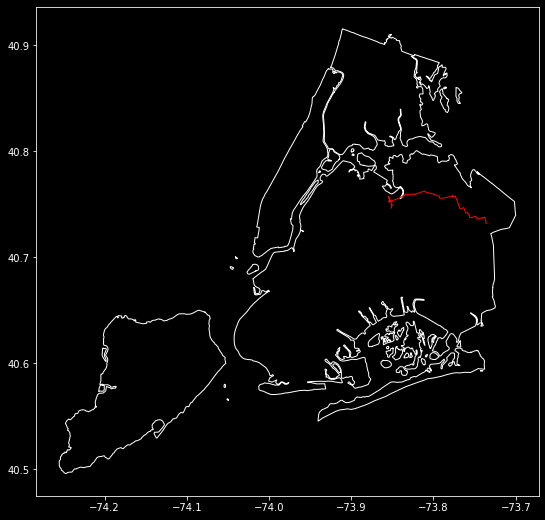

In [21]:
points = np.array(streetsShapeRecs[0].shape.points)
parts = streetsShapeRecs[0].shape.parts
parts.append(points.shape[0])
plt.style.use('dark_background')
plt.figure(figsize=(9,9))
for i in range(len(parts)-1):
    spos = parts[i]
    epos = parts[i+1]
    polygon = points[spos:epos,:]
    plt.plot(polygon[:,0],polygon[:,1],c='w',linewidth=1);
plt.plot(route[:,0],route[:,1],c='r',linewidth=1);

### Tag loose ends

In [13]:
spositions = []
epositions = []
ids = streets['id'].values
for node in nodes:
    if (len(node) == 1):
        for element in node:
            index,edgetype = element,node[element]
            if (edgetype == 's'):
                spositions.append(index)
            else:
                epositions.append(index)
spos = np.zeros((streets.shape[0]))
epos = np.zeros((streets.shape[0]))
spos[spositions] = 1
epos[epositions] = 1
streets['sendpoint'] = spos
streets['eendpoint'] = epos
streets['endpoint'] = spos + epos

### Store

In [14]:
X = {}
X['G'] = G
X['O'] = O
X['N'] = N
X['streets'] = streets
X['coordsdf'] = coordsdf
X['edges'] = edges
X['nodes'] = nodes
X['nodenames'] = nodenames
pickle.dump(X,open('../data/graphs/nyc_' + borough + '.p',"wb"))